In [8]:
# Step 1: Import Libraries
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Step 2: Load the Excel File
file_path = "WalmartRetailSales.xlsx" 
df = pd.read_excel(file_path, sheet_name="Walmart Retail Sales 2012-2015")

In [12]:
df.head()

,Row ID,Order ID,Order Date,Order Priority,Order Quantity,Sales,Discount,Ship Mode,Profit,Unit Price,...,Zip Code,State,Region,Customer Segment,Product Category,Product Sub-Category,Product Name,Product Container,Product Base Margin,Ship Date
0,1914,13729,2001-01-12 00:00:00,Not Specified,9,872.48,0.08,Express Air,-342.91,95.99,...,20715,Maryland,East,Home Office,Office Supplies,Storage & Organization,Safco Industrial Wire Shelving,Large Box,NaN,2001-03-12 00:00:00
1,4031,28774,2001-01-12 00:00:00,High,32,180.36,0.10,Regular Air,-111.80,5.98,...,15131,Pennsylvania,East,Small Business,Office Supplies,Storage & Organization,"Perma STOR-ALL™ Hanging File Box, 13 1/8""W x 1...",Small Box,0.68,2001-02-12 00:00:00
2,1279,9285,2001-02-12 00:00:00,Critical,3,124.81,0.06,Regular Air,-11.94,40.98,...,55372,Minnesota,Central,Consumer,Office Supplies,Binders and Binder Accessories,"Avery Trapezoid Ring Binder, 3"" Capacity, Blac...",Small Box,0.36,2001-04-12 00:00:00
3,5272,37537,2001-02-12 00:00:00,Low,4,1239.06,0.00,Delivery Truck,-193.08,291.73,...,94559,California,West,Corporate,Furniture,Chairs & Chairmats,Hon 4070 Series Pagoda™ Armless Upholstered St...,Jumbo Drum,0.56,2001-02-12 00:00:00
4,5273,37537,2001-02-12 00:00:00,Low,43,4083.19,0.07,Delivery Truck,-1049.85,100.98,...,94559,California,West,Corporate,Furniture,Chairs & Chairmats,Hon Valutask™ Swivel Chairs,Jumbo Drum,0.69,2001-04-12 00:00:00


In [14]:
# Step A: Clean column names (standardize for SQL compatibility)
df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in df.columns]

# Step B: Filter relevant columns only (exclude Customer_Age, City, etc.)
final_columns = [
    'Row_ID', 'Order_ID', 'Order_Date', 'Order_Priority', 'Order_Quantity',
    'Sales', 'Discount', 'Ship_Mode', 'Profit', 'Unit_Price', 'Shipping_Cost',
    'Customer_Name', 'Customer_Segment', 'Product_Category',
    'Product_Sub_Category', 'Product_Name', 'Product_Container',
    'Product_Base_Margin', 'Ship_Date', 'Zip_Code', 'State', 'Region'
]
df = df[final_columns]

# Step C: Handle missing values for SQL compatibility
df = df.where(pd.notnull(df), None)

# Step D: Convert date columns
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'])

In [16]:
df.head()

,Row_ID,Order_ID,Order_Date,Order_Priority,Order_Quantity,Sales,Discount,Ship_Mode,Profit,Unit_Price,...,Customer_Segment,Product_Category,Product_Sub_Category,Product_Name,Product_Container,Product_Base_Margin,Ship_Date,Zip_Code,State,Region
0,1914,13729,2001-01-12,Not Specified,9,872.48,0.08,Express Air,-342.91,95.99,...,Home Office,Office Supplies,Storage & Organization,Safco Industrial Wire Shelving,Large Box,NaN,2001-03-12,20715,Maryland,East
1,4031,28774,2001-01-12,High,32,180.36,0.10,Regular Air,-111.80,5.98,...,Small Business,Office Supplies,Storage & Organization,"Perma STOR-ALL™ Hanging File Box, 13 1/8""W x 1...",Small Box,0.68,2001-02-12,15131,Pennsylvania,East
2,1279,9285,2001-02-12,Critical,3,124.81,0.06,Regular Air,-11.94,40.98,...,Consumer,Office Supplies,Binders and Binder Accessories,"Avery Trapezoid Ring Binder, 3"" Capacity, Blac...",Small Box,0.36,2001-04-12,55372,Minnesota,Central
3,5272,37537,2001-02-12,Low,4,1239.06,0.00,Delivery Truck,-193.08,291.73,...,Corporate,Furniture,Chairs & Chairmats,Hon 4070 Series Pagoda™ Armless Upholstered St...,Jumbo Drum,0.56,2001-02-12,94559,California,West
4,5273,37537,2001-02-12,Low,43,4083.19,0.07,Delivery Truck,-1049.85,100.98,...,Corporate,Furniture,Chairs & Chairmats,Hon Valutask™ Swivel Chairs,Jumbo Drum,0.69,2001-04-12,94559,California,West


In [20]:
# Step 3: MySQL Database Connection Settings
db_user = 'myuser' #Replace with your credentials
db_password = 'mypassword' #Replace with your credentials
db_host = 'localhost'
db_port = '3306'
db_name = '1202project4' #Replace with your database name

# Step 4: Connect using SQLAlchemy
engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

In [22]:
# Step 5: Insert data into MySQL table (replace if exists)
df.to_sql(name='walmartretailsales', con=engine, if_exists='replace', index=False)
print("Data inserted successfully into 'walmartretailsales'.")

# ----------------------------------------------------------------------------------
# Question 1: Is the Sales Growth Rate in Most States Decreasing?
# ----------------------------------------------------------------------------------

query = """
SELECT 
    State,
    YEAR(Order_Date) AS Year,
    ROUND(SUM(Sales), 2) AS Total_Sales
FROM walmartretailsales
GROUP BY State, YEAR(Order_Date)
ORDER BY State, Year;
"""

df_sales = pd.read_sql(query, engine)

Data inserted successfully into 'walmartretailsales'.


In [24]:
# Choose sample states for visualization
sample_states = ['California', 'Texas', 'New York', 'Florida', 'Illinois']
df_sample = df_sales[df_sales['State'].isin(sample_states)]

In [26]:
df_sample.head()

,State,Year,Total_Sales
44,California,2001,61139.17
45,California,2002,57050.05
46,California,2003,54616.94
47,California,2004,61237.18
48,California,2005,48319.01


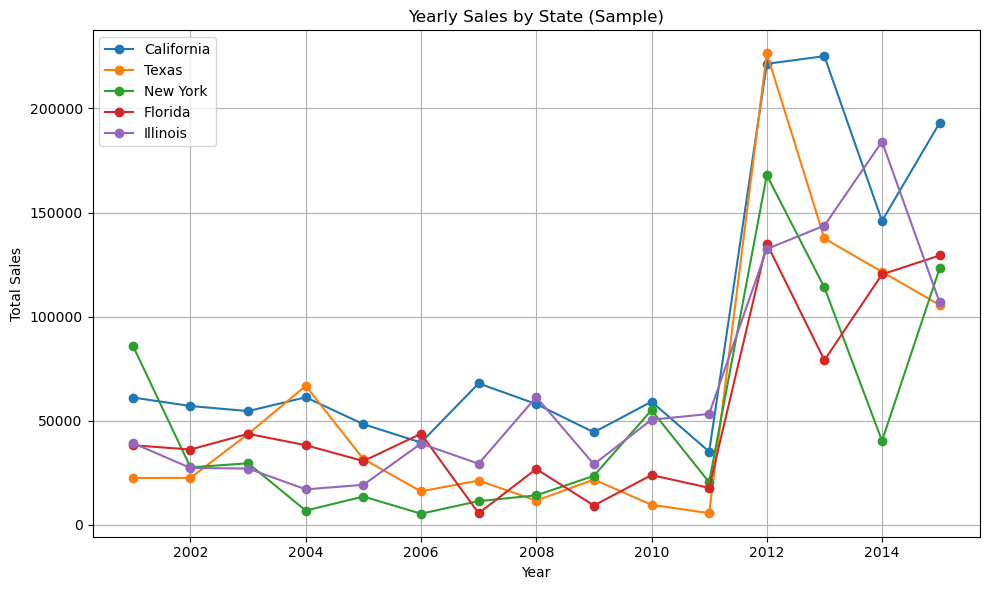

In [28]:
# Plot sales trend
plt.figure(figsize=(10, 6))
for state in sample_states:
    state_data = df_sample[df_sample['State'] == state]
    plt.plot(state_data['Year'], state_data['Total_Sales'], marker='o', label=state)

plt.title('Yearly Sales by State (Sample)')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# ----------------------------------------------------------------------------------
# Question 2: Recommend Products to Maximize Profit
# ----------------------------------------------------------------------------------

query2 = """
SELECT 
    Region,
    Product_Category,
    ROUND(SUM(Profit), 2) AS Total_Profit
FROM walmartretailsales
GROUP BY Region, Product_Category
ORDER BY Region, Total_Profit DESC;
"""

df_profit = pd.read_sql(query2, engine)

In [32]:
df_profit.head()

,Region,Product_Category,Total_Profit
0,Central,Technology,286629.68
1,Central,Office Supplies,162819.08
2,Central,Furniture,32442.44
3,East,Technology,185013.31
4,East,Office Supplies,138124.03


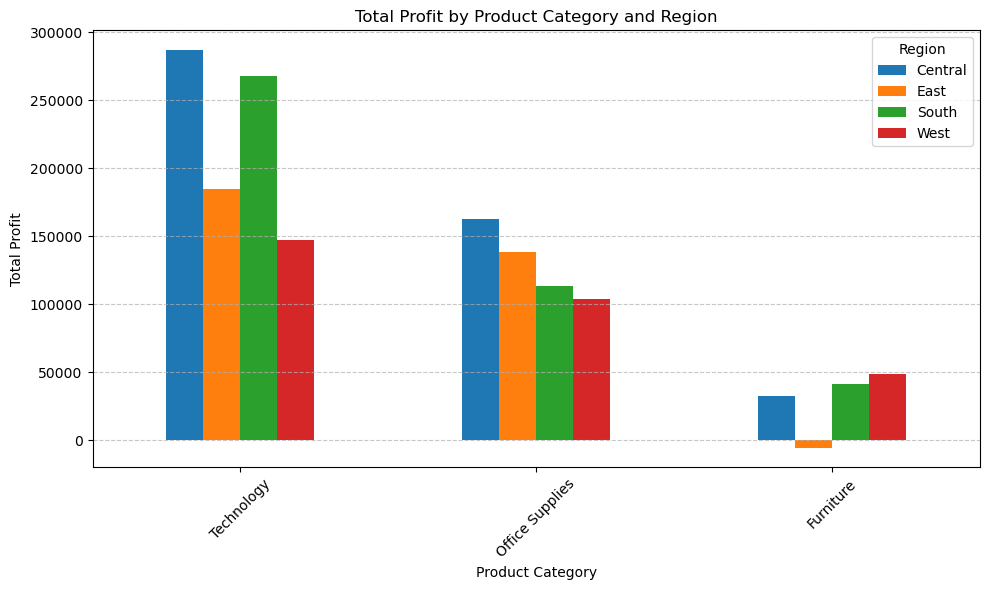

In [34]:
# Pivot for grouped bar chart
pivot_df = df_profit.pivot(index='Product_Category', columns='Region', values='Total_Profit').fillna(0)

# Sort categories by total profit across regions
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('Total', ascending=False).drop(columns='Total')

# Plot grouped bar chart
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Total Profit by Product Category and Region')
plt.xlabel('Product Category')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
# Step 6: Clean up connection 
engine.dispose() 
print("Analysis complete and connection closed.")

Analysis complete and connection closed.
